In [1]:
import numpy as np
import awkward as ak
import uproot_methods

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)

In [4]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [5]:
##and Professor suggests that we could use mass, classifacation for later application
def SetAKArr(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    n_particles_ls = []
    px_ls = []
    py_ls = []
    pz_ls = []
    energy_ls = []
    mass_ls = []
    charge_ls = []
    _label1 = []
    _label2 = []
    _label3 = []
    _label4 = []
    _label5 = []
    
    n = 0
    for line in lines:
        if line.startswith('E'):
            if not n == 0:
                n_particles_ls.append(n)
                n = 0
            exp_inf = line.split()
#             _label1.append(int(exp_inf[1]))
#             _label2.append(1-int(exp_inf[1]))
#             _label1.append(1)
#             _label2.append(0)
            _label1.append(float(exp_inf[1]))
            _label2.append(float(exp_inf[2]))
            _label3.append(float(exp_inf[3]))
            _label4.append(float(exp_inf[4]))
            _label5.append(float(exp_inf[5]))
        else:
            par = line.split()
            ##particle +1
            n = n + 1
            px_ls.append(float(par[2]))
            py_ls.append(float(par[3]))
            pz_ls.append(float(par[4]))
            energy_ls.append(float(par[5]))
            mass_ls.append(float(par[6]))
            charge_ls.append(int(par[0]))
#             px_ls.append(6)
#             py_ls.append(2)
#             pz_ls.append(3)
#             energy_ls.append(4)
#             mass_ls.append(5)
    if not n == 0:
        n_particles_ls.append(n)
    px_arr = np.array(px_ls)
    py_arr = np.array(py_ls)
    pz_arr = np.array(pz_ls)
    energy_arr = np.array(energy_ls)
    mass_arr = np.array(mass_ls)
    charge_arr = np.array(charge_ls)
    n_particles = np.array(n_particles_ls)

#     print(n_particles)
    px = ak.JaggedArray.fromcounts(n_particles, px_arr)
    py = ak.JaggedArray.fromcounts(n_particles, py_arr)
    pz = ak.JaggedArray.fromcounts(n_particles, pz_arr)
    energy = ak.JaggedArray.fromcounts(n_particles, energy_arr)
    mass = ak.JaggedArray.fromcounts(n_particles, mass_arr)
    charge = ak.JaggedArray.fromcounts(n_particles, charge_arr)
    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    ##Create an Order Dic
    from collections import OrderedDict
    v = OrderedDict()
    v['part_px'] = px
#     print(px)
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy
    v['part_mass'] = mass
    v['charge'] = charge
#     v['part_e_log'] = np.log(energy)
#     v['part_px_log'] = np.log(px)
#     v['part_py_log'] = np.log(py)
#     v['part_pz_log'] = np.log(pz)
#     v['part_m_log'] = np.log(mass)
    v['label'] = np.stack((_label1, _label2, _label3, _label4, _label5), axis = -1)
    v['label'] = np.stack(_label5, axis = -1)
#     print(v['label'])
    return v

In [6]:
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label = 'label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict) == 0:
            feature_dict['points'] = ['part_energy', 'part_mass']
            feature_dict['features'] = ['part_energy', 'part_mass', 'charge', 'part_px', 'part_py', 'part_pz']
            feature_dict['mask'] = ['part_energy']
        ##currently we use 'E' for experiments
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()
        
    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
#         counts = None
        a = SetAKArr(self.filepath)
        self._label = a[self.label]
        for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    arrs.append(pad_array(a[col], self.pad_len))
                    ##check the dimesion of a[col], and it should be array.
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)
        
        
        
    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [7]:
train_dataset = Dataset('train.txt', data_format='channel_last')
val_dataset = Dataset('val.txt', data_format='channel_last')
test_dataset = Dataset('test.txt', data_format = 'channel_last')

[2024-05-25 09:57:51,811] INFO: Start loading file train.txt
[2024-05-25 09:57:53,747] INFO: Finished loading file train.txt
[2024-05-25 09:57:53,749] INFO: Start loading file val.txt
[2024-05-25 09:57:53,959] INFO: Finished loading file val.txt
[2024-05-25 09:57:53,960] INFO: Start loading file test.txt
[2024-05-25 09:57:54,185] INFO: Finished loading file test.txt


In [8]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite
from simpleModel import get_simple_model

In [9]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
##this shows the number of classes for classification
try:
    num_classes = train_dataset.y.shape[1]
except:
    num_classes = 1
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)
simple_model = get_simple_model(num_classes, input_shapes)

In [10]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 100

In [11]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [12]:
simple_model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
simple_model.summary()

[2024-05-25 09:58:02,169] INFO: Learning rate: 0.001000


Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 100, 6)]          0         
_________________________________________________________________
dense_2 (Dense)              (None, 100, 1)            7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [13]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
#               metrics=['accuracy'])
# model.compile(loss='log_cosh',
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
#               metrics=['accuracy'])
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2024-05-25 09:58:03,625] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [14]:
from tensorflow.keras.callbacks import Callback
class LossLogger(Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
#         self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a') as f:
#             print("Epoch ", epoch + 1,": loss = ", logs["val_loss"], "\n", file = f)
#             if (epoch+1)%5==0 or epoch==0:
            print('V ', logs['val_loss'], file = f)
            print('L', logs['loss'], file = f)
#             print()
#             f.write()
# loss_logger = LossLogger('MSE_vac_loss.txt')
loss_logger = LossLogger('MSE_loss.txt')

In [15]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='loss.txt',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# I change the monitor from val_acc to val_loss
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, loss_logger]
# callbacks = [lr_schedule]

In [ ]:
# train_dataset.shuffle()
# model.fit(train_dataset.X, train_dataset.y,
#           batch_size=batch_size,
# #           epochs=epochs,
#           epochs=5,
#           validation_data=(val_dataset.X, val_dataset.y),
#           shuffle=True,
#           callbacks=callbacks)

In [33]:
train_dataset.shuffle()
simple_model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=100,
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks
                )

[2024-05-25 10:09:02,103] INFO: Learning rate: 0.001000


Epoch 1/100
68/78 [=========================>....] - ETA: 0s - loss: 7.9519e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,270] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 7.9519e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 7.9520e-12


[2024-05-25 10:09:02,272] INFO: Learning rate: 0.001000


Epoch 2/100
68/78 [=========================>....] - ETA: 0s - loss: 7.9519e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,410] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 7.9519e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 7.9521e-12


[2024-05-25 10:09:02,412] INFO: Learning rate: 0.001000


Epoch 3/100
66/78 [========================>.....] - ETA: 0s - loss: 5.5596e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,554] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 5.5538e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.5224e-12


[2024-05-25 10:09:02,556] INFO: Learning rate: 0.001000


Epoch 4/100
68/78 [=========================>....] - ETA: 0s - loss: 5.5222e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,696] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 5.5222e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.5224e-12


[2024-05-25 10:09:02,698] INFO: Learning rate: 0.001000


Epoch 5/100
75/78 [===========================>..] - ETA: 0s - loss: 5.5222e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,826] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 5.5222e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.5223e-12


[2024-05-25 10:09:02,827] INFO: Learning rate: 0.001000


Epoch 6/100
70/78 [=========================>....] - ETA: 0s - loss: 5.5222e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:02,965] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 5.5222e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.5224e-12


[2024-05-25 10:09:02,967] INFO: Learning rate: 0.001000


Epoch 7/100
71/78 [==========================>...] - ETA: 0s - loss: 5.0747e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,101] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 4.9366e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5350e-12


[2024-05-25 10:09:03,103] INFO: Learning rate: 0.001000


Epoch 8/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,234] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:03,235] INFO: Learning rate: 0.001000


Epoch 9/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,376] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:03,377] INFO: Learning rate: 0.001000


Epoch 10/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,519] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:03,521] INFO: Learning rate: 0.001000


Epoch 11/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,655] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:03,658] INFO: Learning rate: 0.000100


Epoch 12/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,794] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:03,796] INFO: Learning rate: 0.000100


Epoch 13/100
78/78 [==============================] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:03,918] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:03,920] INFO: Learning rate: 0.000100


Epoch 14/100
75/78 [===========================>..] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,048] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5345e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,050] INFO: Learning rate: 0.000100


Epoch 15/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,188] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,189] INFO: Learning rate: 0.000100


Epoch 16/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,321] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,322] INFO: Learning rate: 0.000100


Epoch 17/100
66/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,464] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,465] INFO: Learning rate: 0.000100


Epoch 18/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,598] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5345e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,600] INFO: Learning rate: 0.000100


Epoch 19/100
73/78 [===========================>..] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,730] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:04,732] INFO: Learning rate: 0.000100


Epoch 20/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:04,867] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5348e-12


[2024-05-25 10:09:04,868] INFO: Learning rate: 0.000100


Epoch 21/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,005] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5345e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,007] INFO: Learning rate: 0.000100


Epoch 22/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,142] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,144] INFO: Learning rate: 0.000100


Epoch 23/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,283] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,285] INFO: Learning rate: 0.000100


Epoch 24/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,418] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,420] INFO: Learning rate: 0.000100


Epoch 25/100
73/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,550] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,552] INFO: Learning rate: 0.000100


Epoch 26/100
67/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,691] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,694] INFO: Learning rate: 0.000100


Epoch 27/100
67/78 [========================>.....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,834] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,836] INFO: Learning rate: 0.000100


Epoch 28/100
78/78 [==============================] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:05,959] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:05,960] INFO: Learning rate: 0.000100


Epoch 29/100
40/78 [==============>...............] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,080] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,082] INFO: Learning rate: 0.000100


Epoch 30/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,216] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,218] INFO: Learning rate: 0.000100


Epoch 31/100
67/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,363] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,364] INFO: Learning rate: 0.000100


Epoch 32/100
67/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,503] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,505] INFO: Learning rate: 0.000100


Epoch 33/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,644] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,646] INFO: Learning rate: 0.000100


Epoch 34/100
65/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,788] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,790] INFO: Learning rate: 0.000100


Epoch 35/100
66/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:06,931] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:06,933] INFO: Learning rate: 0.000100


Epoch 36/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,072] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:07,074] INFO: Learning rate: 0.000100


Epoch 37/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,205] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:07,207] INFO: Learning rate: 0.000100


Epoch 38/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,343] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:07,344] INFO: Learning rate: 0.000100


Epoch 39/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,483] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:07,485] INFO: Learning rate: 0.000100


Epoch 40/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,616] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:07,618] INFO: Learning rate: 0.000100


Epoch 41/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,751] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:07,752] INFO: Learning rate: 0.000100


Epoch 42/100
73/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:07,882] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:07,884] INFO: Learning rate: 0.000100


Epoch 43/100
76/78 [============================>.] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,009] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5348e-12


[2024-05-25 10:09:08,011] INFO: Learning rate: 0.000100


Epoch 44/100
76/78 [============================>.] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,136] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:08,138] INFO: Learning rate: 0.000100


Epoch 45/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,273] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5348e-12


[2024-05-25 10:09:08,275] INFO: Learning rate: 0.000100


Epoch 46/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,414] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:08,416] INFO: Learning rate: 0.000100


Epoch 47/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,554] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:08,556] INFO: Learning rate: 0.000100


Epoch 48/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,693] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:08,695] INFO: Learning rate: 0.000100


Epoch 49/100
66/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,834] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5345e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:08,836] INFO: Learning rate: 0.000100


Epoch 50/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:08,970] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:08,971] INFO: Learning rate: 0.000100


Epoch 51/100
73/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,102] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,104] INFO: Learning rate: 0.000100


Epoch 52/100
68/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,243] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,244] INFO: Learning rate: 0.000100


Epoch 53/100
65/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,392] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:09,394] INFO: Learning rate: 0.000100


Epoch 54/100
66/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,534] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,537] INFO: Learning rate: 0.000100


Epoch 55/100
73/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,668] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,670] INFO: Learning rate: 0.000100


Epoch 56/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,802] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,804] INFO: Learning rate: 0.000100


Epoch 57/100
74/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:09,934] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:09,935] INFO: Learning rate: 0.000100


Epoch 58/100
74/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,064] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:10,066] INFO: Learning rate: 0.000100


Epoch 59/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,201] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:10,203] INFO: Learning rate: 0.000100


Epoch 60/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,343] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:10,345] INFO: Learning rate: 0.000100


Epoch 61/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,482] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:10,484] INFO: Learning rate: 0.000100


Epoch 62/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,616] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:10,618] INFO: Learning rate: 0.000100


Epoch 63/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,751] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5345e-12


[2024-05-25 10:09:10,754] INFO: Learning rate: 0.000100


Epoch 64/100
66/78 [========================>.....] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:10,895] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:10,897] INFO: Learning rate: 0.000100


Epoch 65/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,031] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:11,033] INFO: Learning rate: 0.000100


Epoch 66/100
72/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,165] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:11,167] INFO: Learning rate: 0.000100


Epoch 67/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,299] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:11,301] INFO: Learning rate: 0.000100


Epoch 68/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,434] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5346e-12


[2024-05-25 10:09:11,436] INFO: Learning rate: 0.000100


Epoch 69/100
71/78 [==========================>...] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,572] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:11,573] INFO: Learning rate: 0.000100


Epoch 70/100
70/78 [=========================>....] - ETA: 0s - loss: 3.5345e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,707] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5347e-12


[2024-05-25 10:09:11,709] INFO: Learning rate: 0.000100


Epoch 71/100
74/78 [===========================>..] - ETA: 0s - loss: 3.5346e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,836] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.5346e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.5348e-12


[2024-05-25 10:09:11,838] INFO: Learning rate: 0.000100


Epoch 72/100
72/78 [==========================>...] - ETA: 0s - loss: 2.6976e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:11,971] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.6431e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9882e-12


[2024-05-25 10:09:11,973] INFO: Learning rate: 0.000100


Epoch 73/100
75/78 [===========================>..] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,100] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9883e-12


[2024-05-25 10:09:12,102] INFO: Learning rate: 0.000100


Epoch 74/100
72/78 [==========================>...] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,235] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9883e-12


[2024-05-25 10:09:12,237] INFO: Learning rate: 0.000100


Epoch 75/100
70/78 [=========================>....] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,373] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9882e-12


[2024-05-25 10:09:12,375] INFO: Learning rate: 0.000100


Epoch 76/100
70/78 [=========================>....] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,512] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9883e-12


[2024-05-25 10:09:12,514] INFO: Learning rate: 0.000100


Epoch 77/100
68/78 [=========================>....] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,656] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9884e-12


[2024-05-25 10:09:12,658] INFO: Learning rate: 0.000100


Epoch 78/100
68/78 [=========================>....] - ETA: 0s - loss: 1.9884e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,799] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.9884e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.9883e-12


[2024-05-25 10:09:12,801] INFO: Learning rate: 0.000100


Epoch 79/100
69/78 [=========================>....] - ETA: 0s - loss: 1.8766e-12 - accuracy: 0.0000e+00

[2024-05-25 10:09:12,941] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 1.7623e-12 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8442e-13


[2024-05-25 10:09:12,943] INFO: Learning rate: 0.000100


Epoch 80/100
72/78 [==========================>...] - ETA: 0s - loss: 8.8439e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,075] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8439e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8404e-13


[2024-05-25 10:09:13,076] INFO: Learning rate: 0.000100


Epoch 81/100
70/78 [=========================>....] - ETA: 0s - loss: 8.8430e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,218] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8430e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8429e-13


[2024-05-25 10:09:13,221] INFO: Learning rate: 0.000100


Epoch 82/100
69/78 [=========================>....] - ETA: 0s - loss: 8.8429e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,358] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8430e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8416e-13


[2024-05-25 10:09:13,360] INFO: Learning rate: 0.000100


Epoch 83/100
66/78 [========================>.....] - ETA: 0s - loss: 8.8429e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,504] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8428e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8456e-13


[2024-05-25 10:09:13,506] INFO: Learning rate: 0.000100


Epoch 84/100
66/78 [========================>.....] - ETA: 0s - loss: 8.8433e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,646] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8433e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8404e-13


[2024-05-25 10:09:13,647] INFO: Learning rate: 0.000100


Epoch 85/100
70/78 [=========================>....] - ETA: 0s - loss: 8.8432e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,783] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8432e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8473e-13


[2024-05-25 10:09:13,785] INFO: Learning rate: 0.000100


Epoch 86/100
61/78 [======================>.......] - ETA: 0s - loss: 8.8431e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:13,932] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8431e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8416e-13


[2024-05-25 10:09:13,933] INFO: Learning rate: 0.000100


Epoch 87/100
71/78 [==========================>...] - ETA: 0s - loss: 8.8432e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,067] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8432e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8482e-13


[2024-05-25 10:09:14,069] INFO: Learning rate: 0.000100


Epoch 88/100
64/78 [=======================>......] - ETA: 0s - loss: 8.8437e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,220] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8435e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8492e-13


[2024-05-25 10:09:14,222] INFO: Learning rate: 0.000100


Epoch 89/100
70/78 [=========================>....] - ETA: 0s - loss: 8.8439e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,357] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 8.8439e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.8397e-13


[2024-05-25 10:09:14,358] INFO: Learning rate: 0.000100


Epoch 90/100
69/78 [=========================>....] - ETA: 0s - loss: 3.5624e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,497] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 3.4060e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2056e-13


[2024-05-25 10:09:14,498] INFO: Learning rate: 0.000100


Epoch 91/100
66/78 [========================>.....] - ETA: 0s - loss: 2.2057e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,645] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2057e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2057e-13


[2024-05-25 10:09:14,647] INFO: Learning rate: 0.000100


Epoch 92/100
65/78 [========================>.....] - ETA: 0s - loss: 2.2058e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,788] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2058e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2058e-13


[2024-05-25 10:09:14,791] INFO: Learning rate: 0.000100


Epoch 93/100
69/78 [=========================>....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:14,928] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2061e-13


[2024-05-25 10:09:14,929] INFO: Learning rate: 0.000100


Epoch 94/100
70/78 [=========================>....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,063] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2058e-13


[2024-05-25 10:09:15,065] INFO: Learning rate: 0.000100


Epoch 95/100
69/78 [=========================>....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,205] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2058e-13


[2024-05-25 10:09:15,207] INFO: Learning rate: 0.000100


Epoch 96/100
67/78 [========================>.....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,349] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2059e-13


[2024-05-25 10:09:15,351] INFO: Learning rate: 0.000100


Epoch 97/100
70/78 [=========================>....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,485] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2058e-13


[2024-05-25 10:09:15,487] INFO: Learning rate: 0.000100


Epoch 98/100
69/78 [=========================>....] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,624] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2058e-13


[2024-05-25 10:09:15,625] INFO: Learning rate: 0.000100


Epoch 99/100
72/78 [==========================>...] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,757] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2059e-13


[2024-05-25 10:09:15,759] INFO: Learning rate: 0.000100


Epoch 100/100
74/78 [===========================>..] - ETA: 0s - loss: 2.2059e-13 - accuracy: 0.0000e+00

[2024-05-25 10:09:15,888] WARNING: Can save best model only with val_acc available, skipping.


78/78 [==============================] - 0s 2ms/step - loss: 2.2059e-13 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.2059e-13


In [34]:
# with open('MSE_pre_100epoches.txt', 'w') as file:
#     predictions = model.predict(test_dataset.X)
#     for prediction in predictions:
#         print(prediction, file = file)

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
def PlotPrediction(filepath, fig, tag):
    #open files
    with open(filepath, 'r') as file:
        lines = file.readlines()
    output = open('100pre_MEPoint.txt', 'w')
        
    ##this piece of code would load the 
    ##real particle infor in order to be compared with the predictions
    true_vals = []
    true_val = []
    masses = []
    for line in lines:
        if line.startswith('E'):
            if not true_val:
                true_vals.append(true_val)
            true_val = []
            info = line.split()
            px = float(info[1])
            py = float(info[2])
            pz = float(info[3])
            engy = float(info[4])
            mass = float(info[5])
            true_val.append(px)
            true_val.append(py)
            true_val.append(pz)
            true_val.append(engy)
            true_val.append(mass)
            if tag == 'Px':
                masses.append(px)
            elif tag == 'Py':
                masses.append(py)
            elif tag == 'Pz':
                masses.append(pz)
            elif tag == 'Engy':
                masses.append(engy)
            else:
                masses.append(mass)
    
    predictions = model.predict(test_dataset.X)
    
    x = []
    for i in range(0, predictions.size):
        x.append(i)
        i += 1
    quans = []
##this is for multiple output variables
#     if tag == 'Px':
#         idx = 0
#     elif tag == 'Py':
#         idx = 1
#     elif tag == 'Pz':
#         idx = 2
#     elif tag == 'Engy':
#         idx = 3
#     else:
#         idx = 4
    #idx = mass
    idx = 0
    for prediction in predictions:
        #this would grab the desired information
        quan = prediction[idx]
        quans.append(quan)
        ##his would output the prediction into text
        for energy_momentum in prediction:
            print(energy_momentum, end='', file=output)
        print('', file=output)
        
#     fig, ax = plt.subplots()
#     ax.set_title("Mass Prediction")
#     plt.xlabel("Number of Prediction")
#     plt.ylabel("Mass")
#     ax.scatter(x, masses, linewidth=2.0, color = 'blue')

    plt.hist(quans, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    plt.hist(masses, 40, label='prediction', density=False, histtype = 'step', cumulative=False, color = 'b', alpha = 0.75)
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)

#     plt.legend(
#     loc='best',
#     labels = ['log_cosh', 'mse'])
#     plt.show()
    plt.savefig(fig)

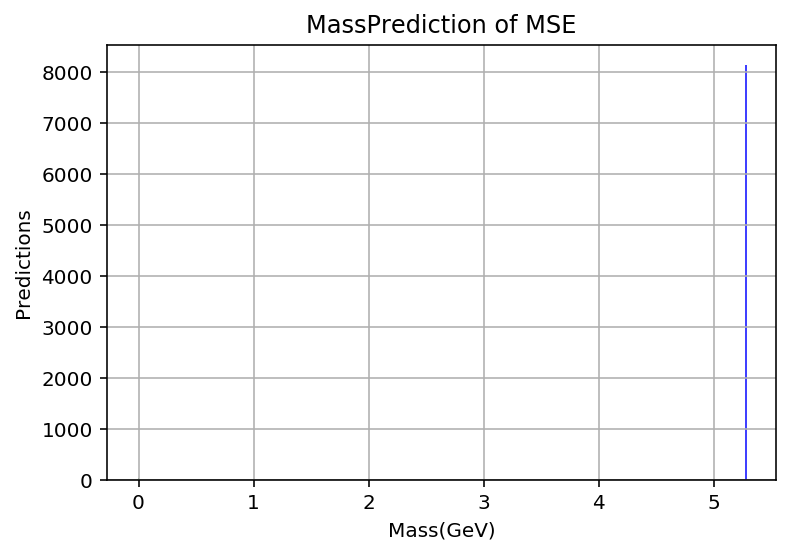

In [36]:
PlotPrediction('test.txt','predictions/Mass_100epPre.png','Mass')

In [37]:
def PlotWithoutModel(filepath, fig, tag):
    TrueMass = 5.27933
    with open(filepath, 'r') as file:
        lines = file.readlines()
    masses = []
    for line in lines:
        masses.append(float(line))
    plt.hist(masses, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    # Mark True mass
    plt.axvline(TrueMass, color='red', linestyle='--', label='Marked Point')
    
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)
    plt.savefig(fig)

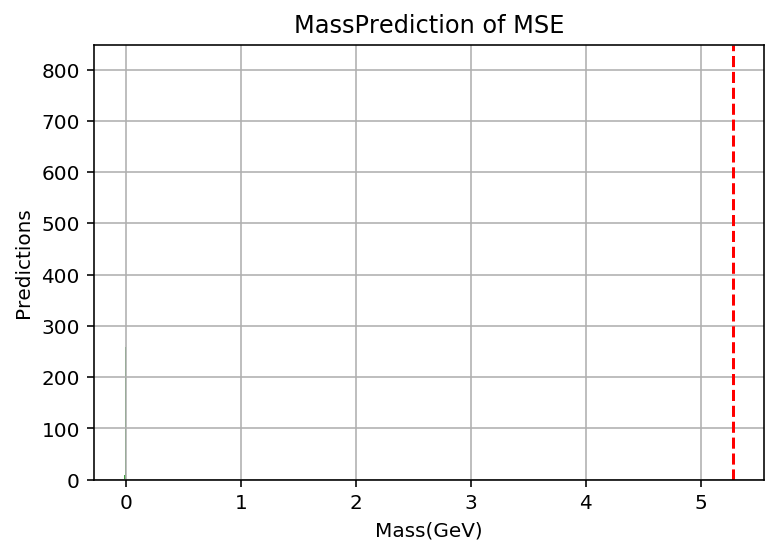

In [38]:
PlotWithoutModel('100pre_MEPoint.txt', '100masspre.png', 'Mass')